<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

print(tf.version.VERSION)

TensorFlow 2.x selected.
2.1.0-rc1


In [32]:
import IPython
import plotly._widget_version as v
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

print(v.__frontend_version__)
def configure_plotly_browser_state():
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
#configure_plotly_browser_state()
#init_notebook_mode(connected=False)


^1.1.1


In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [19]:
configure_plotly_browser_state()
import plotly.express as px
fig = go.Figure(
    data=go.Heatmap(z=train_images[0])
)
fig.update_layout(
    autosize = False
)
iplot(fig)

In [27]:
configure_plotly_browser_state()
from ipywidgets import Output, VBox

fig = go.FigureWidget()
pie = fig.add_pie(values=[1, 2, 3])

out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    print(points.point_inds)

#print(type(pie.data[0]))
pie.data[0].on_click(handle_click)

VBox([fig, out])

    'data': [{'type': 'pie', 'uid': '0f4e29c0-22e6-425e-b33c-98078f7d3743', 'val…

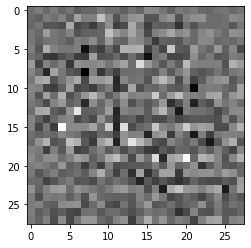

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(np.array(generated_image)[0, :, :, 0], cmap='gray')